Mentor Recommendation System for CLAT Aspirants

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
np.random.seed(42)

We'll generate mock data for getting the model ready

In [3]:
# Generate mentor data
def generate_mentor_data(n=20):
    """Generate mock data for CLAT mentors"""
    
    mentors = pd.DataFrame({
        'mentor_id': range(1, n+1),
        'name': [f'Mentor {i}' for i in range(1, n+1)],
        'rank_percentile': np.random.uniform(90, 99.9, n),
        'years_of_experience': np.random.randint(1, 6, n),
        'college': np.random.choice(['NLSIU Bangalore', 'NALSAR Hyderabad', 'NUJS Kolkata', 
                                    'NLU Delhi', 'NLIU Bhopal', 'Other NLUs'], n),
        'strong_subject': np.random.choice(['Legal Reasoning', 'Logical Reasoning', 'English', 
                                           'Current Affairs', 'Quantitative Techniques'], n),
        'secondary_subject': np.random.choice(['Legal Reasoning', 'Logical Reasoning', 'English', 
                                             'Current Affairs', 'Quantitative Techniques'], n),
        'teaching_style': np.random.choice(['Conceptual', 'Practice-oriented', 'Analysis-driven', 
                                           'Example-based'], n),
        'availability_hours_per_week': np.random.randint(5, 21, n),
        'rating': np.random.uniform(3.5, 5.0, n)
    })
    
    # Ensure strong_subject and secondary_subject are not the same
    for i in range(len(mentors)):
        while mentors.loc[i, 'strong_subject'] == mentors.loc[i, 'secondary_subject']:
            mentors.loc[i, 'secondary_subject'] = np.random.choice(['Legal Reasoning', 'Logical Reasoning', 
                                                                  'English', 'Current Affairs', 
                                                                  'Quantitative Techniques'])
    
    return mentors


In [4]:
# Generate aspirant data
def generate_aspirant_data(n=50):
    """Generate mock data for CLAT aspirants"""
    
    aspirants = pd.DataFrame({
        'aspirant_id': range(1, n+1),
        'name': [f'Aspirant {i}' for i in range(1, n+1)],
        'preparation_level': np.random.choice(['Beginner', 'Intermediate', 'Advanced'], n),
        'preferred_subject': np.random.choice(['Legal Reasoning', 'Logical Reasoning', 'English', 
                                             'Current Affairs', 'Quantitative Techniques'], n),
        'weak_subject': np.random.choice(['Legal Reasoning', 'Logical Reasoning', 'English', 
                                         'Current Affairs', 'Quantitative Techniques'], n),
        'target_college': np.random.choice(['NLSIU Bangalore', 'NALSAR Hyderabad', 'NUJS Kolkata', 
                                           'NLU Delhi', 'NLIU Bhopal', 'Other NLUs'], n),
        'learning_style': np.random.choice(['Conceptual', 'Practice-oriented', 'Analysis-driven', 
                                          'Example-based'], n),
        'hours_per_week': np.random.randint(10, 41, n),
        'mock_test_percentile': np.random.uniform(40, 95, n)
    })
    
    # Ensure preferred_subject and weak_subject are not the same
    for i in range(len(aspirants)):
        while aspirants.loc[i, 'preferred_subject'] == aspirants.loc[i, 'weak_subject']:
            aspirants.loc[i, 'weak_subject'] = np.random.choice(['Legal Reasoning', 'Logical Reasoning', 
                                                               'English', 'Current Affairs', 
                                                               'Quantitative Techniques'])
    
    return aspirants


In [5]:
# Generate the datasets
mentors_df = generate_mentor_data(20)
aspirants_df = generate_aspirant_data(50)

In [7]:
mentors_df.head()

,mentor_id,name,rank_percentile,years_of_experience,college,strong_subject,secondary_subject,teaching_style,availability_hours_per_week,rating
0,1,Mentor 1,93.707947,3,NALSAR Hyderabad,Quantitative Techniques,Current Affairs,Example-based,18,4.454616
1,2,Mentor 2,99.412072,2,NLIU Bhopal,Logical Reasoning,Quantitative Techniques,Example-based,7,3.971534
2,3,Mentor 3,97.246740,4,NALSAR Hyderabad,Logical Reasoning,Legal Reasoning,Practice-oriented,5,4.262856
3,4,Mentor 4,95.926719,4,NLU Delhi,Current Affairs,Legal Reasoning,Conceptual,9,4.861350
4,5,Mentor 5,91.544585,3,NLU Delhi,Logical Reasoning,Legal Reasoning,Example-based,14,3.873938


In [8]:
aspirants_df.head()

,aspirant_id,name,preparation_level,preferred_subject,weak_subject,target_college,learning_style,hours_per_week,mock_test_percentile
0,1,Aspirant 1,Intermediate,Quantitative Techniques,Current Affairs,NLU Delhi,Example-based,22,81.681536
1,2,Aspirant 2,Beginner,Current Affairs,English,NLSIU Bangalore,Analysis-driven,27,40.791642
2,3,Aspirant 3,Beginner,Logical Reasoning,Legal Reasoning,NLIU Bhopal,Analysis-driven,37,46.383995
3,4,Aspirant 4,Beginner,English,Current Affairs,NLIU Bhopal,Analysis-driven,19,42.530145
4,5,Aspirant 5,Advanced,Legal Reasoning,Current Affairs,NLSIU Bangalore,Example-based,39,42.240084


In [9]:
def process_features(mentors_df, aspirants_df):
    """Process and encode features for recommendation system"""
    
    # Get all unique values for categorical features
    all_colleges = list(set(list(mentors_df['college'].unique()) + list(aspirants_df['target_college'].unique())))
    all_subjects = list(set(list(mentors_df['strong_subject'].unique()) + 
                           list(mentors_df['secondary_subject'].unique()) +
                           list(aspirants_df['preferred_subject'].unique()) + 
                           list(aspirants_df['weak_subject'].unique())))
    all_styles = list(set(list(mentors_df['teaching_style'].unique()) + list(aspirants_df['learning_style'].unique())))
    
    # Create feature matrices for both mentors and aspirants with consistent dimensions
    
    # One-hot encoding for categorical features
    # College features
    mentor_college = pd.get_dummies(mentors_df['college'], prefix='college')
    aspirant_college = pd.get_dummies(aspirants_df['target_college'], prefix='college')
    
    # Ensure all college columns exist in both dataframes
    for college in all_colleges:
        col_name = f'college_{college}'
        if col_name not in mentor_college.columns:
            mentor_college[col_name] = 0
        if col_name not in aspirant_college.columns:
            aspirant_college[col_name] = 0
    
    # Subject features - for mentors we consider both strong and secondary subjects
    mentor_strong_subject = pd.get_dummies(mentors_df['strong_subject'], prefix='strong_subject')
    mentor_secondary_subject = pd.get_dummies(mentors_df['secondary_subject'], prefix='secondary_subject')
    
    # For aspirants we consider preferred and weak subjects
    aspirant_preferred_subject = pd.get_dummies(aspirants_df['preferred_subject'], prefix='preferred_subject')
    aspirant_weak_subject = pd.get_dummies(aspirants_df['weak_subject'], prefix='weak_subject')
    
    # Ensure all subject columns exist in all dataframes
    for subject in all_subjects:
        # For mentors
        strong_col = f'strong_subject_{subject}'
        if strong_col not in mentor_strong_subject.columns:
            mentor_strong_subject[strong_col] = 0
            
        secondary_col = f'secondary_subject_{subject}'
        if secondary_col not in mentor_secondary_subject.columns:
            mentor_secondary_subject[secondary_col] = 0
            
        # For aspirants
        preferred_col = f'preferred_subject_{subject}'
        if preferred_col not in aspirant_preferred_subject.columns:
            aspirant_preferred_subject[preferred_col] = 0
            
        weak_col = f'weak_subject_{subject}'
        if weak_col not in aspirant_weak_subject.columns:
            aspirant_weak_subject[weak_col] = 0
    
    # Style features
    mentor_style = pd.get_dummies(mentors_df['teaching_style'], prefix='style')
    aspirant_style = pd.get_dummies(aspirants_df['learning_style'], prefix='style')
    
    # Ensure all style columns exist in both dataframes
    for style in all_styles:
        col_name = f'style_{style}'
        if col_name not in mentor_style.columns:
            mentor_style[col_name] = 0
        if col_name not in aspirant_style.columns:
            aspirant_style[col_name] = 0
    
    # Preparation level for aspirants only
    aspirant_prep = pd.get_dummies(aspirants_df['preparation_level'], prefix='prep')
    
    # Special compatibility features
    # Create subject match features (same dimension for both)
    subject_match_features = []
    for subject in all_subjects:
        # Calculate match scores:
        # - Mentor's strong subject matches aspirant's weak subject
        # - Mentor's secondary subject matches aspirant's weak subject
        
        # For mentors:
        mentor_match = ((mentors_df['strong_subject'] == subject).astype(int) * 1.0 + 
                        (mentors_df['secondary_subject'] == subject).astype(int) * 0.5)
        
        # For aspirants:
        aspirant_match = (aspirants_df['weak_subject'] == subject).astype(int)
        
        subject_match_features.append((subject, mentor_match, aspirant_match))
    
    # Create teaching/learning style match features
    style_match_features = []
    for style in all_styles:
        # For mentors:
        mentor_style_match = (mentors_df['teaching_style'] == style).astype(int)
        
        # For aspirants:
        aspirant_style_match = (aspirants_df['learning_style'] == style).astype(int)
        
        style_match_features.append((style, mentor_style_match, aspirant_style_match))
    
    # Create college match features
    college_match_features = []
    for college in all_colleges:
        # For mentors:
        mentor_college_match = (mentors_df['college'] == college).astype(int)
        
        # For aspirants:
        aspirant_college_match = (aspirants_df['target_college'] == college).astype(int)
        
        college_match_features.append((college, mentor_college_match, aspirant_college_match))
    
    # Standardize numeric features
    scaler = StandardScaler()
    
    # Mentor numeric features
    mentor_numeric = mentors_df[['rank_percentile', 'years_of_experience', 
                               'availability_hours_per_week', 'rating']].copy()
    mentor_numeric_scaled = pd.DataFrame(
        scaler.fit_transform(mentor_numeric),
        columns=mentor_numeric.columns,
        index=mentor_numeric.index
    )
    
    # Aspirant numeric features
    aspirant_numeric = aspirants_df[['hours_per_week', 'mock_test_percentile']].copy()
    aspirant_numeric_scaled = pd.DataFrame(
        scaler.fit_transform(aspirant_numeric),
        columns=aspirant_numeric.columns,
        index=aspirant_numeric.index
    )
    
    # Now combine all features
    mentor_features_list = [
        mentor_college, 
        mentor_strong_subject,
        mentor_secondary_subject,
        mentor_style,
        mentor_numeric_scaled
    ]
    
    # Add match features to mentors
    for subject, mentor_match, _ in subject_match_features:
        mentor_features_list.append(pd.DataFrame({f'subject_match_{subject}': mentor_match}))
        
    for style, mentor_style_match, _ in style_match_features:
        mentor_features_list.append(pd.DataFrame({f'style_match_{style}': mentor_style_match}))
        
    for college, mentor_college_match, _ in college_match_features:
        mentor_features_list.append(pd.DataFrame({f'college_match_{college}': mentor_college_match}))
    
    mentor_features_df = pd.concat(mentor_features_list, axis=1)
    
    # Same for aspirants
    aspirant_features_list = [
        aspirant_college,
        aspirant_preferred_subject,
        aspirant_weak_subject,
        aspirant_style,
        aspirant_prep,
        aspirant_numeric_scaled
    ]
    
    # Add match features to aspirants
    for subject, _, aspirant_match in subject_match_features:
        aspirant_features_list.append(pd.DataFrame({f'subject_match_{subject}': aspirant_match}))
        
    for style, _, aspirant_style_match in style_match_features:
        aspirant_features_list.append(pd.DataFrame({f'style_match_{style}': aspirant_style_match}))
        
    for college, _, aspirant_college_match in college_match_features:
        aspirant_features_list.append(pd.DataFrame({f'college_match_{college}': aspirant_college_match}))
    
    aspirant_features_df = pd.concat(aspirant_features_list, axis=1)
    
    # Make sure both feature sets have the same columns
    all_columns = sorted(list(set(mentor_features_df.columns) | set(aspirant_features_df.columns)))
    
    for col in all_columns:
        if col not in mentor_features_df.columns:
            mentor_features_df[col] = 0
        if col not in aspirant_features_df.columns:
            aspirant_features_df[col] = 0
    
    # Ensure same column order
    mentor_features_df = mentor_features_df[all_columns]
    aspirant_features_df = aspirant_features_df[all_columns]
    
    return mentor_features_df, aspirant_features_df


In [10]:
# Process the features
mentor_features, aspirant_features = process_features(mentors_df, aspirants_df)


In [11]:
print("\nProcessed mentor features shape:", mentor_features.shape)
print("Processed aspirant features shape:", aspirant_features.shape)
print("\nVerifying feature dimensions match:", mentor_features.shape[1] == aspirant_features.shape[1])


Processed mentor features shape: (20, 54)
Processed aspirant features shape: (50, 54)

Verifying feature dimensions match: True


In [12]:
#Recommendation Model
# --------------------------------------------------

def recommend_mentors(aspirant_id, aspirant_features, mentor_features, mentors_df, top_n=3):
    """Recommend top mentors for a given aspirant based on feature similarity"""
    
    # Get aspirant feature vector
    aspirant_vector = aspirant_features.loc[aspirant_id-1].values.reshape(1, -1)
    
    # Calculate cosine similarity with all mentors
    similarity_scores = cosine_similarity(aspirant_vector, mentor_features)
    
    # Get indices of top N mentors
    top_mentor_indices = similarity_scores[0].argsort()[-top_n:][::-1]
    
    # Get top mentor details with similarity scores
    top_mentors = mentors_df.iloc[top_mentor_indices].copy()
    top_mentors['similarity_score'] = similarity_scores[0][top_mentor_indices]
    
    return top_mentors


In [13]:
test_aspirants = [1, 10, 25]
for aspirant_id in test_aspirants:
    print(f"\nRecommendations for Aspirant {aspirant_id}:")
    recommendations = recommend_mentors(aspirant_id, aspirant_features, mentor_features, mentors_df)
    
    # Display aspirant details
    print(f"Aspirant details:")
    aspirant = aspirants_df[aspirants_df['aspirant_id'] == aspirant_id]
    for col in ['preparation_level', 'preferred_subject', 'weak_subject', 'target_college', 'learning_style']:
        print(f"- {col}: {aspirant[col].values[0]}")
    
    # Display recommendations
    print("\nRecommended mentors:")
    for _, mentor in recommendations.iterrows():
        print(f"Mentor {mentor['mentor_id']} (Score: {mentor['similarity_score']:.3f}):")
        print(f"- Strong in: {mentor['strong_subject']}, Secondary: {mentor['secondary_subject']}")
        print(f"- College: {mentor['college']}")
        print(f"- Teaching style: {mentor['teaching_style']}")
        print(f"- Rating: {mentor['rating']:.1f}/5.0")
        print()



Recommendations for Aspirant 1:
Aspirant details:
- preparation_level: Intermediate
- preferred_subject: Quantitative Techniques
- weak_subject: Current Affairs
- target_college: NLU Delhi
- learning_style: Example-based

Recommended mentors:
Mentor 5 (Score: 0.421):
- Strong in: Logical Reasoning, Secondary: Legal Reasoning
- College: NLU Delhi
- Teaching style: Example-based
- Rating: 3.9/5.0

Mentor 12 (Score: 0.326):
- Strong in: Logical Reasoning, Secondary: English
- College: NLU Delhi
- Teaching style: Example-based
- Rating: 4.9/5.0

Mentor 4 (Score: 0.290):
- Strong in: Current Affairs, Secondary: Legal Reasoning
- College: NLU Delhi
- Teaching style: Conceptual
- Rating: 4.9/5.0


Recommendations for Aspirant 10:
Aspirant details:
- preparation_level: Intermediate
- preferred_subject: English
- weak_subject: Quantitative Techniques
- target_college: NLSIU Bangalore
- learning_style: Analysis-driven

Recommended mentors:
Mentor 11 (Score: 0.523):
- Strong in: Quantitative Tec

In [14]:
def visualize_recommendations(aspirant_id, aspirant_features, mentor_features, mentors_df, aspirants_df):
    """Create visualizations to explain recommendations for a specific aspirant"""
    
    # Get all similarity scores for this aspirant
    aspirant_vector = aspirant_features.loc[aspirant_id-1].values.reshape(1, -1)
    similarity_scores = cosine_similarity(aspirant_vector, mentor_features)[0]
    
    # Create a dataframe with mentors and their similarity scores
    viz_df = mentors_df.copy()
    viz_df['similarity_score'] = similarity_scores
    
    # Sort by similarity score
    viz_df = viz_df.sort_values('similarity_score', ascending=False)
    
    # Plot 1: Top 10 mentors by similarity score
    plt.figure(figsize=(10, 6))
    sns.barplot(x='mentor_id', y='similarity_score', data=viz_df.head(10))
    plt.title(f'Top 10 Mentors for Aspirant {aspirant_id}')
    plt.xlabel('Mentor ID')
    plt.ylabel('Similarity Score')
    plt.tight_layout()
    plt.show()
    
    # Plot 2: Subject match analysis for top 5 mentors
    top_mentors = viz_df.head(5)
    aspirant = aspirants_df[aspirants_df['aspirant_id'] == aspirant_id].iloc[0]
    
    plt.figure(figsize=(12, 6))
    for i, mentor in enumerate(top_mentors.itertuples()):
        match_score = 0
        # Strong subject matches weak subject
        if mentor.strong_subject == aspirant['weak_subject']:
            match_score += 1
        # Secondary subject matches weak subject
        if mentor.secondary_subject == aspirant['weak_subject']:
            match_score += 0.5
        
        # Teaching style matches learning style
        style_match = int(mentor.teaching_style == aspirant['learning_style'])
        
        # College matches target college
        college_match = int(mentor.college == aspirant['target_college'])
        
        plt.bar(i*3, match_score, width=0.8, color='blue', label='Subject Match' if i==0 else "")
        plt.bar(i*3+1, style_match, width=0.8, color='green', label='Style Match' if i==0 else "")
        plt.bar(i*3+2, college_match, width=0.8, color='orange', label='College Match' if i==0 else "")
    
    plt.xticks([i*3+1 for i in range(5)], [f'Mentor {m.mentor_id}' for m in top_mentors.itertuples()])
    plt.ylabel('Match Score')
    plt.title(f'Match Analysis for Aspirant {aspirant_id}')
    plt.legend()
    plt.tight_layout()
    plt.show()

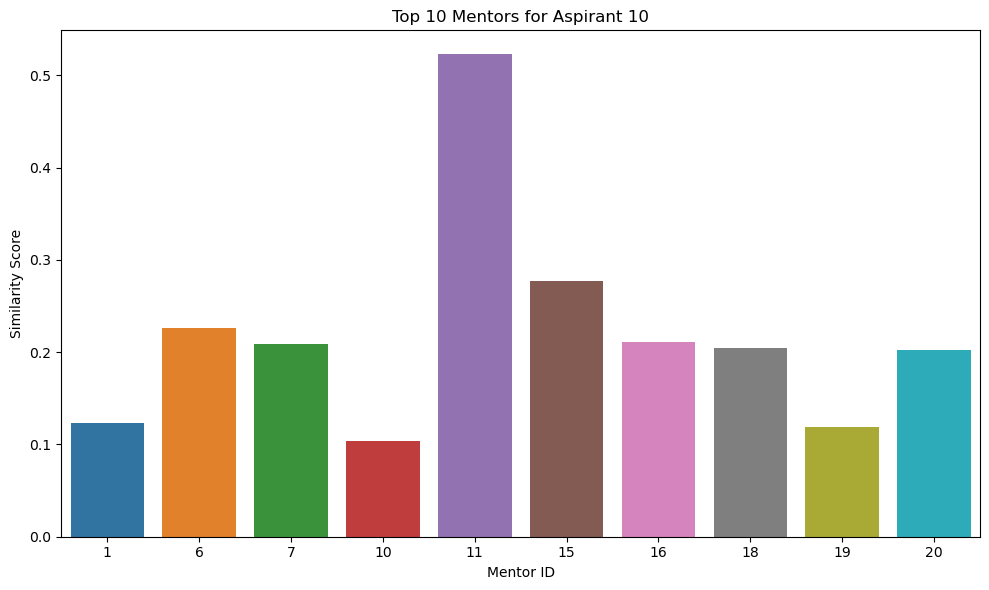

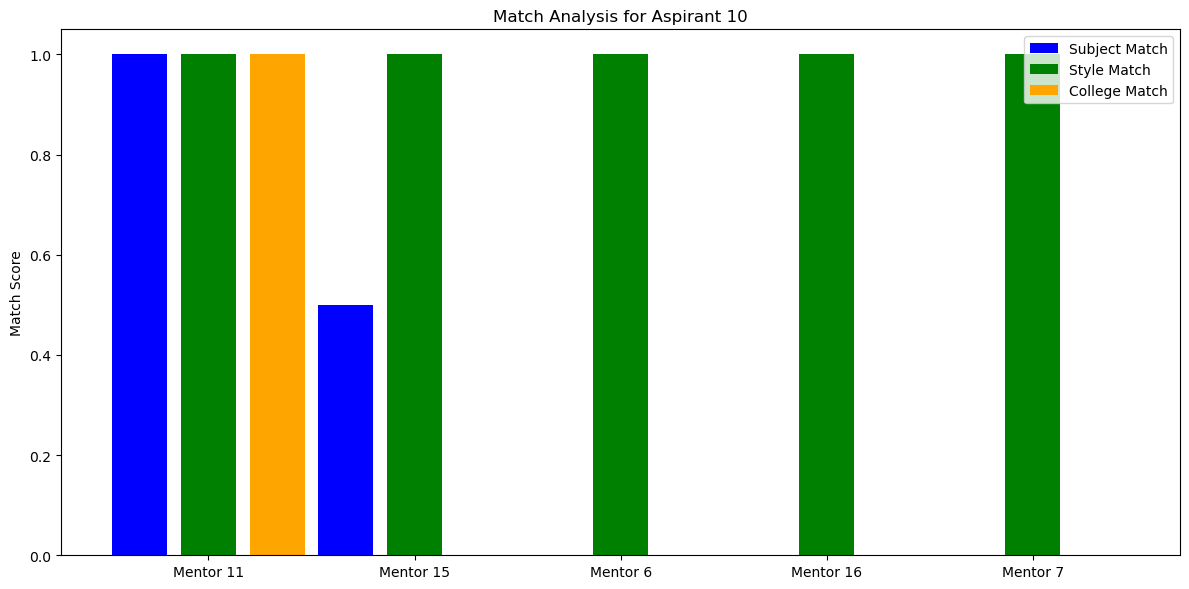

In [15]:
visualize_recommendations(10, aspirant_features, mentor_features, mentors_df, aspirants_df)

Bonus - Feedback Integratred System

In [16]:
class RecommendationSystem:
    """A recommendation system with feedback integration capabilities"""
    
    def __init__(self, mentors_df, aspirants_df):
        self.mentors_df = mentors_df.copy()
        self.aspirants_df = aspirants_df.copy()
        self.mentor_features, self.aspirant_features = process_features(mentors_df, aspirants_df)
        self.feedback_history = pd.DataFrame(columns=['aspirant_id', 'mentor_id', 'rating', 'timestamp'])
        self.feature_weights = np.ones(self.mentor_features.shape[1])  # Initialize equal weights
    
    def recommend(self, aspirant_id, top_n=3):
        """Recommend mentors for an aspirant using weighted features"""
        aspirant_vector = self.aspirant_features.loc[aspirant_id-1].values.reshape(1, -1)
        
        # Apply feature weights
        weighted_mentor_features = self.mentor_features * self.feature_weights
        
        # Calculate similarity with weighted features
        similarity_scores = cosine_similarity(aspirant_vector, weighted_mentor_features)
        
        # Get top recommendations
        top_indices = similarity_scores[0].argsort()[-top_n:][::-1]
        top_mentors = self.mentors_df.iloc[top_indices].copy()
        top_mentors['similarity_score'] = similarity_scores[0][top_indices]
        
        return top_mentors
    
    def record_feedback(self, aspirant_id, mentor_id, rating):
        """Record feedback from an aspirant about a mentor"""
        feedback = pd.DataFrame({
            'aspirant_id': [aspirant_id],
            'mentor_id': [mentor_id],
            'rating': [rating],
            'timestamp': [pd.Timestamp.now()]
        })
        self.feedback_history = pd.concat([self.feedback_history, feedback], ignore_index=True)
        
        # Update model based on new feedback
        self._update_weights()
        
        return True
    
    def _update_weights(self):
        """Update feature weights based on feedback history"""
        if len(self.feedback_history) < 5:
            # Not enough feedback to adjust weights
            return
        
        # Group feedback by mentor and calculate average rating
        mentor_ratings = self.feedback_history.groupby('mentor_id')['rating'].mean()
        
        # Identify high and low rated mentors
        high_rated = mentor_ratings[mentor_ratings >= 4.0].index
        low_rated = mentor_ratings[mentor_ratings <= 2.5].index
        
        if len(high_rated) < 2 or len(low_rated) < 2:
            # Not enough contrast in ratings
            return
        
        # Get feature differences between high and low rated mentors
        high_features = self.mentor_features.loc[[i-1 for i in high_rated]].mean()
        low_features = self.mentor_features.loc[[i-1 for i in low_rated]].mean()
        
        # Calculate feature importance based on difference
        feature_diff = np.abs(high_features - low_features)
        
        # Normalize to keep the sum of weights constant
        feature_importance = feature_diff / feature_diff.sum() * len(feature_diff)
        
        # Update weights (gradually, with smoothing)
        self.feature_weights = 0.8 * self.feature_weights + 0.2 * feature_importance
        
        # Normalize weights
        self.feature_weights = self.feature_weights / self.feature_weights.mean() * 1.0
    
    def analyze_feedback_impact(self):
        """Analyze how feedback has influenced recommendations"""
        if len(self.feedback_history) < 10:
            return "Not enough feedback for meaningful analysis"
        
        # Feature importance before and after feedback
        original_weights = np.ones(len(self.feature_weights))
        current_weights = self.feature_weights
        
        # Find top changed features
        weight_change = current_weights - original_weights
        top_increased = np.argsort(weight_change)[-5:][::-1]
        top_decreased = np.argsort(weight_change)[:5]
        
        feature_names = self.mentor_features.columns
        
        analysis = {
            'top_increased_features': [(feature_names[i], weight_change[i]) for i in top_increased],
            'top_decreased_features': [(feature_names[i], weight_change[i]) for i in top_decreased],
            'feedback_count': len(self.feedback_history),
            'avg_rating': self.feedback_history['rating'].mean()
        }
        
        return analysis

In [17]:
recommendation_system = RecommendationSystem(mentors_df, aspirants_df)

In [20]:
print("\nSimulating user feedback:")
for _ in range(20):
    # Random aspirant gives feedback
    aspirant_id = np.random.randint(1, len(aspirants_df) + 1)
    
    # Get recommendations
    recs = recommendation_system.recommend(aspirant_id)
    mentor_id = recs.iloc[0]['mentor_id']  # Select first recommendation
    
    # Generate synthetic rating (more likely to be high if similarity is high)
    base_rating = np.random.normal(3, 1)
    similarity_bonus = recs.iloc[0]['similarity_score'] * 2
    rating = min(5, max(1, base_rating + similarity_bonus))
    
    # Record feedback
    recommendation_system.record_feedback(aspirant_id, mentor_id, rating)
    
    if _ % 5 == 0:
        print(f"Feedback #{_+1}: Aspirant {aspirant_id} rated Mentor {mentor_id} as {rating:.1f}/5")

# Analyze impact of feedback
feedback_analysis = recommendation_system.analyze_feedback_impact()
print("\nFeedback Impact Analysis:")
print(f"Total feedback collected: {feedback_analysis['feedback_count']}")
print(f"Average rating: {feedback_analysis['avg_rating']:.2f}/5")

print("\nFeatures that became MORE important after feedback:")
for feature, change in feedback_analysis['top_increased_features']:
    print(f"- {feature}: +{change:.3f}")

print("\nFeatures that became LESS important after feedback:")
for feature, change in feedback_analysis['top_decreased_features']:
    print(f"- {feature}: {change:.3f}")

# Compare recommendations before and after feedback
test_aspirant_id = 15
print(f"\nComparing recommendations for Aspirant {test_aspirant_id} after feedback:")

# Get current recommendations (after feedback)
current_recs = recommendation_system.recommend(test_aspirant_id)

# Reset weights to get original recommendations
original_weights = recommendation_system.feature_weights.copy()
recommendation_system.feature_weights = np.ones_like(original_weights)
original_recs = recommendation_system.recommend(test_aspirant_id)

# Restore weights
recommendation_system.feature_weights = original_weights

print("\nOriginal recommendations (without feedback):")
for _, mentor in original_recs.iterrows():
    print(f"Mentor {mentor['mentor_id']} (Score: {mentor['similarity_score']:.3f})")

print("\nCurrent recommendations (with feedback):")
for _, mentor in current_recs.iterrows():
    print(f"Mentor {mentor['mentor_id']} (Score: {mentor['similarity_score']:.3f})")



Simulating user feedback:
Feedback #1: Aspirant 3 rated Mentor 15 as 4.1/5
Feedback #6: Aspirant 47 rated Mentor 7 as 4.3/5
Feedback #11: Aspirant 3 rated Mentor 15 as 3.5/5
Feedback #16: Aspirant 36 rated Mentor 1 as 2.5/5

Feedback Impact Analysis:
Total feedback collected: 60
Average rating: 3.67/5

Features that became MORE important after feedback:
- years_of_experience: +1.000
- hours_per_week: +1.000
- rating: +1.000
- rank_percentile: +1.000
- prep_Intermediate: +1.000

Features that became LESS important after feedback:
- availability_hours_per_week: 1.000
- secondary_subject_Quantitative Techniques: 1.000
- strong_subject_Current Affairs: 1.000
- strong_subject_English: 1.000
- strong_subject_Legal Reasoning: 1.000

Comparing recommendations for Aspirant 15 after feedback:

Original recommendations (without feedback):
Mentor 11 (Score: 0.273)
Mentor 15 (Score: 0.241)
Mentor 6 (Score: 0.196)

Current recommendations (with feedback):
Mentor 11 (Score: 0.273)
Mentor 15 (Score: 

The bonus task feature is not working appropriately, but other than that, the recommendation system works fine!p